This article employs multiple unsupervised learning approaches to extract insights of the stock market. First, we use hierarchical cluster analysis to broadly cluster stocks based on similarity matrix. Then, we proceed to visualize the stock market structure by using sparse inverse covariance to determine partial correlation between each pair of stocks, and using Manifold learning to plot the structure on a 2D canvas.

We will first download stock prices from Yahoo, and then calculate returns. The universe consists of stocks in the US, Thailand and China.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
plt.style.use('ggplot')

import pandas as pd
from pandas_datareader import data

from sklearn import cluster, covariance, manifold
from scipy.cluster.hierarchy import dendrogram, linkage

start_dt = '2020-01-01'
end_dt = '2020-12-31'

stock_dict = {
    '^GSPC': 'S&P 500',
    'AMZN': 'Amazon',
    'AAPL': 'Apple',
    'ACN': 'Accenture',
    'AIG': 'AIG',
    'BAC': 'Bank of America',
    'BA': 'Boeing',
    'BCS': 'Barclays',
    'BRK-B': 'Berkshire',
    'BLK': 'Blackrock',
    'BNPQY': 'BNP Paribas SA',
    'BK': 'BNY Mellon',
    'C': 'Citi',
    'CAJ': 'Canon',
    'COP': 'Conoco Phillips',
    'CMCSA': 'Comcast',
    'CSCO': 'Cisco',
    'CVS': 'CVS',
    'DELL': 'Dell',
    'F': 'Ford',
    'FB': 'Facebook',
    'GOOG': 'Google',
    'GE': 'General Electric',
    'GS': 'Goldman Sachs',
    'HMC': 'Honda',
    'HPQ': 'HP',
    'IBM': 'IBM',
    'IVR': 'Invesco',
    'INTU': 'Intuit',
    'IFNNY': 'Infineon',
    'JPM': 'JPMorgan Chase',
    'KO': 'Coca Cola',
    'MSFT': 'Microsoft',
    'MA': 'Mastercard',
    'MAR': 'Marriott',
    'MCO': 'Moodys',
    'NOC': 'Nothrop Grumman',
    'PYPL': 'PayPal',
    'PEP': 'Pepsi',
    'PFE': 'Pfizer',
    'PNC': 'PNC',
    'PG': 'Proctor Gamble',
    'PUK': 'Prudential',
    'SAN': 'Banco Santander',
    'SCHW': 'Charles Schwab',
    'TM': 'Toyota',
    'TSLA': 'Tesla',
    'TFC': 'Truist',
    'UN': 'Unilever',
    'UBS': 'UBS',
    'V': 'Visa',
    'WMT': 'WalMart',
    'WFC': 'Wells Fargo',
    'SCB.BK': 'Siam Commercial Bank',
    'KBANK.BK': 'Kbank',
    'BBL.BK': 'Bangkok Bank',
    'PTT.BK': 'PTT',
    'AOT.BK': 'AOT',
    'BTS.BK': 'BTS',
    'BEM.BK': 'BEM',
    'IDCBF': 'IDCBF',
    'CICHF': 'CICHF',
    'PNGAY': 'Ping An',
    'BACHF': 'Bank of China',
    'BABA': 'Alibaba'
}

stock_list = list(stock_dict.keys())

# Load stock prices
df = data.DataReader(stock_list, 'yahoo', start_dt, end_dt)
df.columns = df.columns.get_level_values(0)
df = df.iloc[:,:len(stock_list)]
df.columns = stock_list

# Calculate returns
df = df.diff()/df.shift()
df = df.dropna()
df

,^GSPC,AMZN,AAPL,ACN,AIG,BAC,BA,BCS,BRK-B,BLK,...,BBL.BK,PTT.BK,AOT.BK,BTS.BK,BEM.BK,IDCBF,CICHF,PNGAY,BACHF,BABA
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.007060,-0.012139,-0.009722,-0.001666,-0.007728,-0.020763,-0.001680,-0.025615,-0.009676,-0.010629,...,-0.018349,0.021978,-0.016611,-0.007463,0.009174,0.000000,-0.034483,-0.003702,0.000000,-0.012604
2020-01-06,0.003533,0.014886,0.007968,-0.006530,0.000779,-0.001433,0.002945,-0.002103,0.003581,0.000854,...,-0.028037,0.010753,-0.023649,-0.015038,-0.009091,-0.012821,0.000000,0.002890,-0.023256,-0.001659
2020-01-07,-0.002803,0.002092,-0.004703,-0.021590,-0.005642,-0.006600,0.010607,0.002107,-0.004714,0.006389,...,0.003205,0.005319,0.020761,0.030534,0.036697,-0.012987,0.047619,-0.004529,0.000000,0.004570
2020-01-08,0.004902,-0.007809,0.016086,0.001962,0.011739,0.010110,-0.017523,0.002103,0.000310,-0.000237,...,-0.022364,-0.010582,-0.010169,-0.007408,-0.008850,0.000000,0.000000,-0.003309,0.000000,0.001700
2020-01-09,0.006655,0.004799,0.021241,0.008907,0.011023,0.001716,0.014998,-0.002099,0.011770,0.011832,...,0.009804,0.005348,0.017123,0.014926,-0.008929,0.013158,0.011364,0.005809,0.023810,0.017339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19,0.003946,0.003722,0.005168,0.014475,-0.000259,0.000000,0.011658,0.000000,-0.002347,0.005359,...,0.000000,-0.006579,0.003745,-0.009615,0.000000,-0.016393,-0.012987,-0.007343,0.000000,0.015870
2020-11-20,-0.006793,-0.005653,-0.010958,0.000987,0.001816,-0.006301,-0.029416,-0.006803,-0.010979,-0.001143,...,0.025424,0.013245,0.011194,0.019417,0.010929,-0.016667,0.000000,-0.002176,-0.054054,0.041748
2020-11-23,0.005636,-0.000326,-0.029743,0.011337,0.030044,0.021634,0.059663,0.026027,0.011145,0.015103,...,0.020661,0.058824,0.007380,0.019048,0.021622,0.000000,-0.013158,-0.001308,0.028572,-0.002327


### Hierarchical Clustering

The idea of hierarchical clustering to group similar samples into groups called clusters. It repeatedly merge the two most similar clusters until there is only one big cluster. One can use raw data or a distance (dissimilarity) matrix for the clustering. In this example, we will use a transfromed version of correlation matrix to represent dissimilarity. The more common alternative is to just use raw features or a Euclidean distance matrix.

After selecting the distance or dissimilarity matrix, we need to determine from where the distance between clusters is computed. For example, $single$-$linkage$ uses the two most similar parts between two clusters, $complete$-$linkage$ uses the two least similar parts, $ward$ computes the sum of squared distances from the average and chooses to merge clusters that minimize the value, and so on. In this example, we use $ward$ for the linkage criteria.

In [2]:
def cluster(X, 
            dis_func = lambda x: np.sqrt(1 - x**2), 
            ft = ['S&P 500']):
    
    corr = np.corrcoef(X)
    dissimilarity = dis_func(corr)
    
    fig, ax = plt.subplots(1, 1, figsize = (24,10), facecolor = 'w')
    plt.title('Hierarchical Clustering Dendogram of Stocks', fontsize = 20)
    plt.xlabel('Stock')
    plt.ylabel('Distance')
    dendrogram(linkage(dissimilarity, 'ward', optimal_ordering = True), 
               labels = [stock_dict[s] for s in X.index], 
               leaf_rotation = 90., 
               leaf_font_size = 20.)
    
    for lbl in ax.get_xticklabels():
        if lbl.get_text() in ft:
            lbl.set_color('red')
        else:
            lbl.set_color('black')

$Dissimilarity = \sqrt{1-Corr^2}$

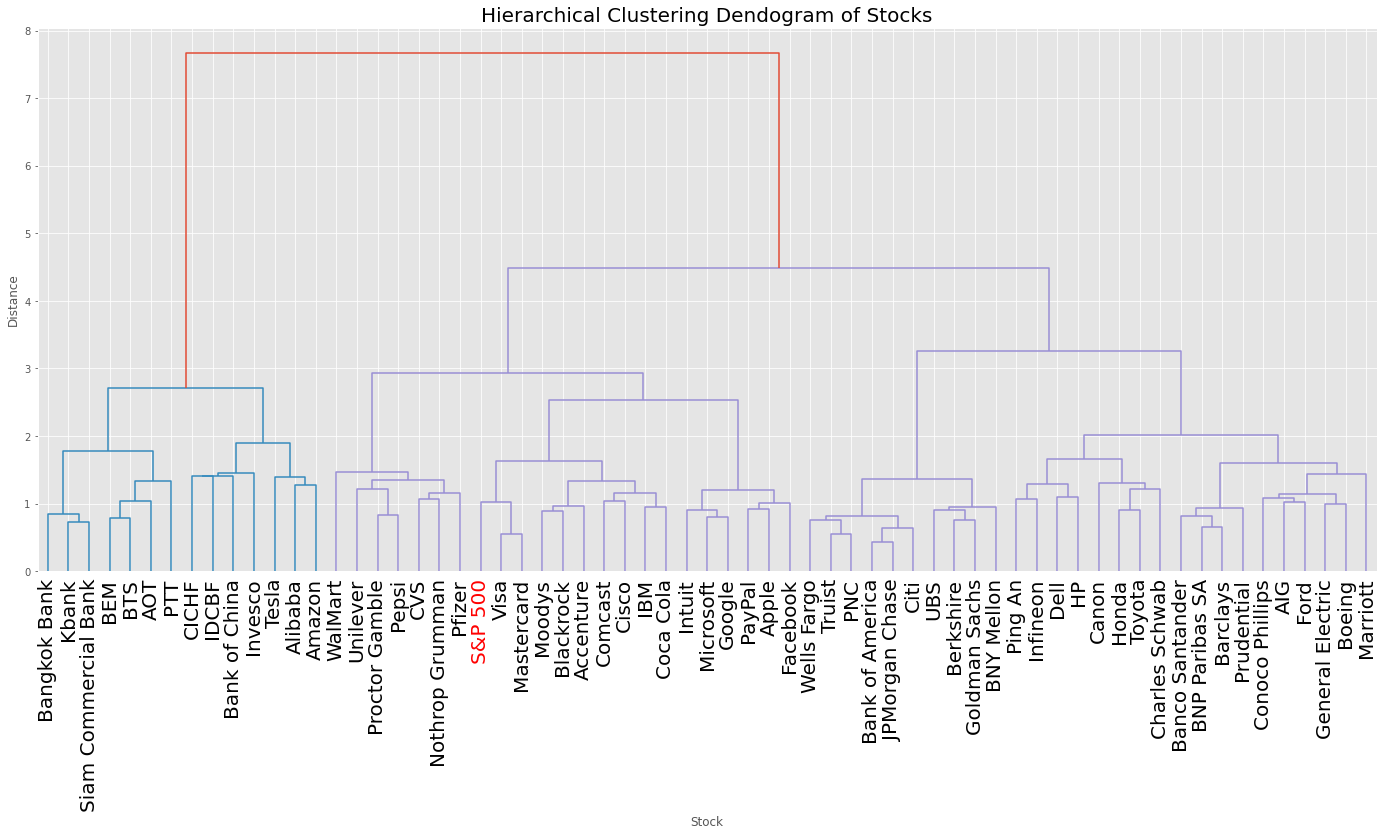

In [3]:
cluster(df.T)

$Dissimilarity = 1-|Corr|$

<ipython-input-2-1d1ceac3aeb5>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram(linkage(dissimilarity, 'ward', optimal_ordering = True),


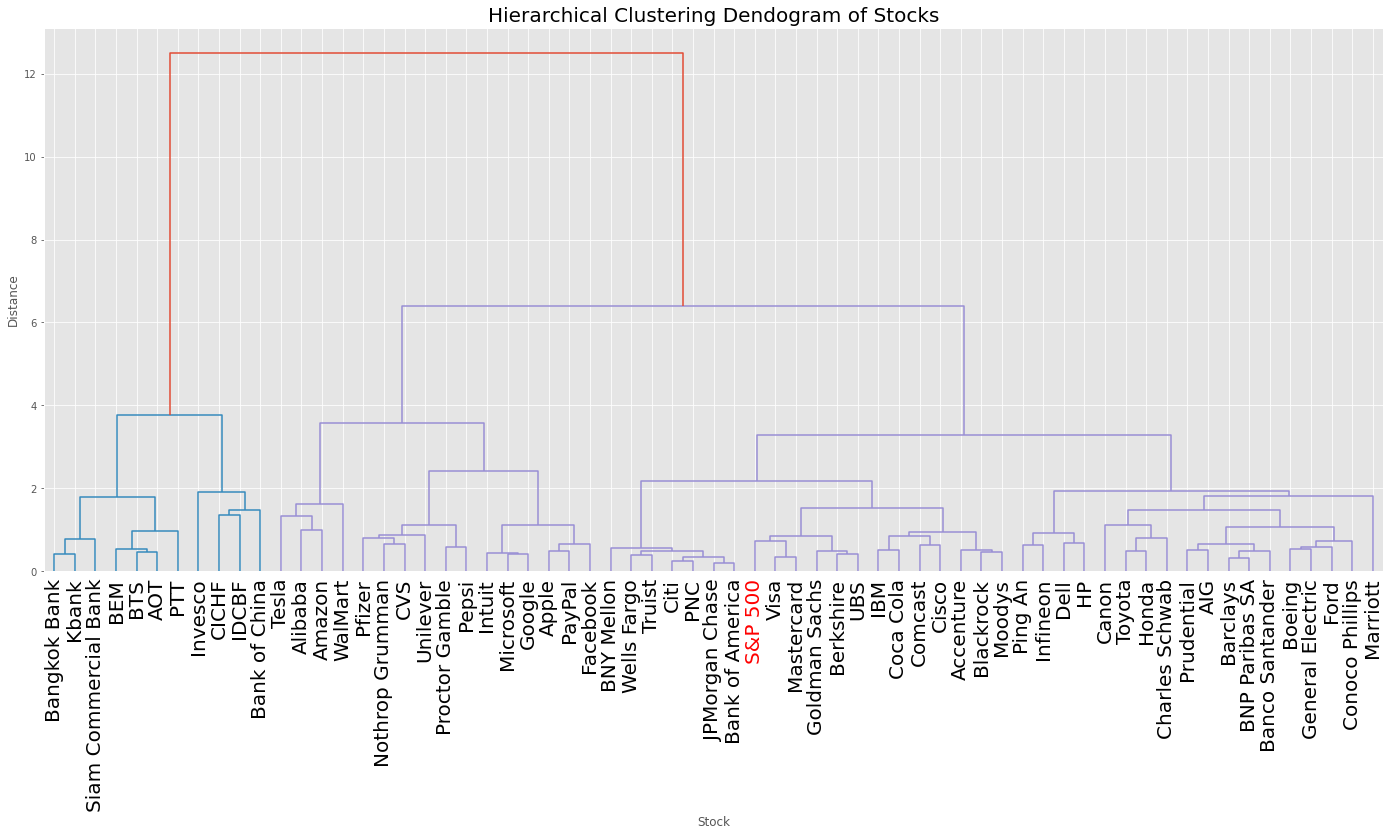

In [4]:
cluster(df.T, lambda x: 1 - np.abs(x))

We can see that both dissimilarity matrices give similar results. Stocks in the same industry tend to cluster in the same group. Unsurprisingly, most stocks are grouped closely to those in the same industry or country.

### Graphical Structure

#### Partial Correlation Matrix

Now, we will learn graphical structure of stocks from their correlations. We use sparse inverse covariance estimation to find which stocks are correlated conditionally on the others. In other words, we compute sparse covariance and mathematically the inverse of it is a precision matrix, which is proportional to partial correlation matrix. The idea of partial correlation is that the partial correlation between $x$ and $y$ is zero if and only if $x$ is conditionally independent from $y$ given $z$.

We use graphical lasso, which performs penalized maximum likelihood with a lasso penalty on the inverse covariance matrix, to estimate the precision matrix. This is a nice approach to force some partial correlations to be zero while preventing expensive computational cost in case of large number of features (or stocks). It is recommended to standardize the time-series before fitting.

In [5]:
edge_model = covariance.GraphicalLassoCV()

# Standardize input
X = df.copy()
X -= X.mean(0)
X /= X.std(0)

# Fit
edge_model.fit(X)

GraphicalLassoCV()

[Text(0.5, 1.0, 'sample inverse covariance')]

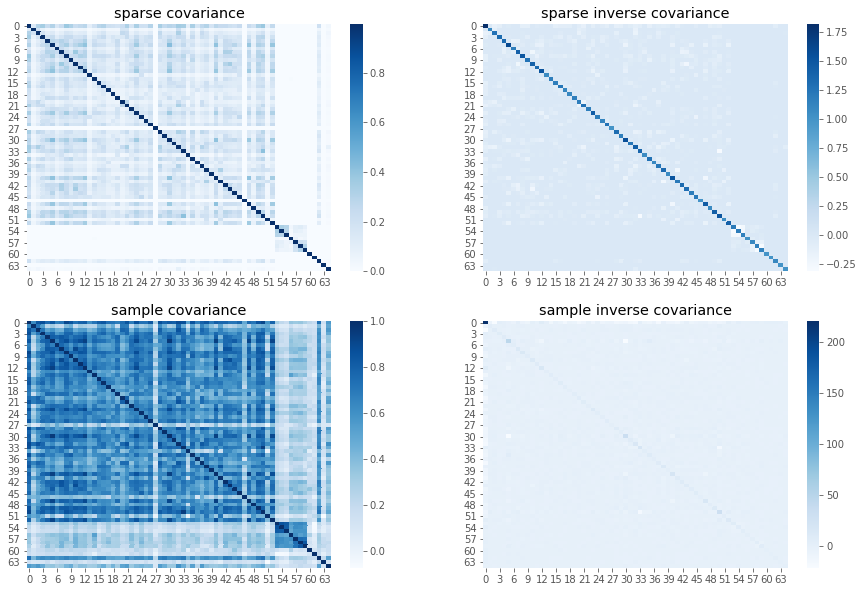

In [6]:
fig, axs = plt.subplots(2, 2, figsize = (15,10))
sns.heatmap(edge_model.covariance_, ax = axs[0,0], cmap = 'Blues').set(title = 'sparse covariance')
sns.heatmap(edge_model.precision_, ax = axs[0,1], cmap = 'Blues').set(title = 'sparse inverse covariance')
sns.heatmap(np.cov(X.T), ax = axs[1,0], cmap = 'Blues').set(title = 'sample covariance')
sns.heatmap(np.linalg.inv(np.cov(X.T)), ax = axs[1,1], cmap = 'Blues').set(title = 'sample inverse covariance')

The plots confirm that by using graphical lasso, most members in the precision matrix are forced to be zero while the conventional sample inverse covariance matrix do not contain any zero.

In [7]:
print('Graphical Lasso')
print('0s in Covariance', np.argwhere(edge_model.covariance_ == 0).shape[0])
print('0s in Precision', np.argwhere(edge_model.precision_ == 0).shape[0])

print('Sample Covariance')
print('0s in Covariance', np.argwhere(np.cov(X.T) == 0).shape[0])
print('0s in Precision', np.argwhere(np.linalg.inv(np.cov(X.T)) == 0).shape[0])

Graphical Lasso
0s in Covariance 500
0s in Precision 3072
Sample Covariance
0s in Covariance 0
0s in Precision 0


#### Clustering

The next step is to cluster stocks that behave similarly. We use Affinity Propagation where each data point sends messages to all other points informing attractiveness of each target of the sender, then each target responds to all senders informing its availability to associate with the sender. The passing proceeds until convergence. The advantage of this method is that it does not require you to specify the number of clusters.

In [12]:
from sklearn import cluster
_, labels = cluster.affinity_propagation(edge_model.covariance_)

n_label = labels.max()
for i in range(n_label):
    print('Cluster %i: %s' % (i+1, ', '.join(X.columns[labels == i])))

Cluster 1: ^GSPC, AMZN, AAPL, ACN, BRK-B, BLK, CMCSA, CSCO, CVS, DELL, FB, GOOG, HMC, HPQ, IBM, INTU, IFNNY, KO, MSFT, MA, MCO, NOC, PYPL, PEP, PFE, PG, TM, UN, UBS, V, WMT, PNGAY
Cluster 2: BAC, BK, C, CAJ, COP, F, GE, GS, JPM, PNC, SCHW, TFC, WFC
Cluster 3: AIG, BA, BCS, BNPQY, MAR, PUK, SAN
Cluster 4: IVR
Cluster 5: TSLA
Cluster 6: SCB.BK, KBANK.BK, BBL.BK
Cluster 7: PTT.BK
Cluster 8: AOT.BK, BTS.BK, BEM.BK
Cluster 9: IDCBF
Cluster 10: CICHF
Cluster 11: BACHF


#### Embedding in 2D

Lastly, find a low-dimension embedding for visualization. We use Locally Linear Embedding technique to unwrap manifolds of a high dimension data.

In [13]:
node_position_model = manifold.LocallyLinearEmbedding(n_components = 2,
                                                      eigen_solver = 'dense',
                                                      n_neighbors = 6)

embedding = node_position_model.fit_transform(X.T).T
print(embedding.shape)

(2, 65)


The plot is then generated by using matplotlib. 

Text(0.5, 1.0, 'Graph Structure')

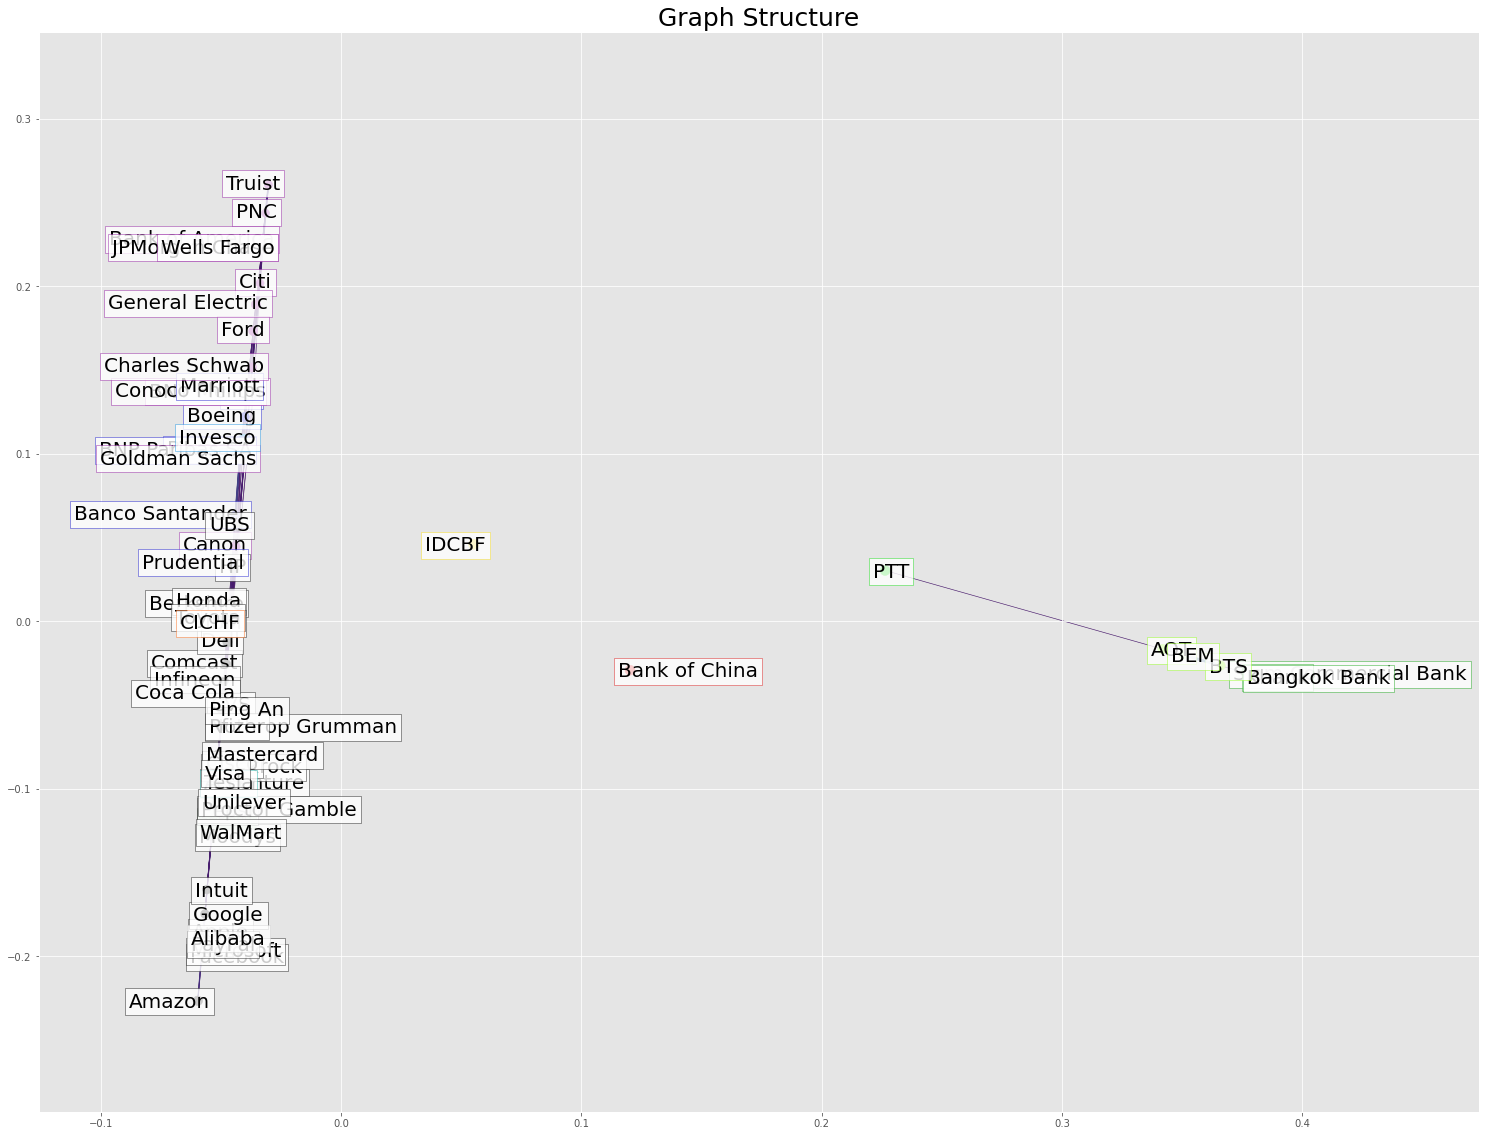

In [14]:
plt.figure(1, facecolor = 'w', figsize = (20,15))
plt.clf()
ax = plt.axes([0. ,0. ,1., 1.])

partial_corr = edge_model.precision_.copy()
d = 1/np.sqrt(np.diag(partial_corr))
partial_corr *= d
partial_corr *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_corr)) >= 0.05)

# Plot nodes
plt.scatter(embedding[0], embedding[1], c = labels, s = 100*d**2, 
            cmap = plt.cm.nipy_spectral)

# Plot edges
start_idx, end_idx = np.where(non_zero)
segments = [[embedding[:,start], embedding[:,stop]] for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_corr[non_zero])

lc = LineCollection(segments, 
                    zorder = 0, 
                    norm = plt.Normalize(0, .9*values.max()))
lc.set_array(values)
lc.set_linewidths(10*values)
ax.add_collection(lc)

for index, (name, label, (x,y)) in enumerate(zip(list(stock_dict.values()), labels, embedding.T)):
    
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[0]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    
    if this_dx > 0:
        horizontal_alignment = 'left'
        x -= 0.005
    else:
        horizontal_alignment = 'right'
        x += 0.005
    if this_dy > 0:
        vertical_alignment = 'bottom'
        y -= 0.005
    else:
        vertical_alignment = 'top'
        y += 0.005
        
    if name == 'S&P 500':
        plt.text(x, y, name, size=12,
                 horizontalalignment=horizontal_alignment,
                 verticalalignment=vertical_alignment,
                 bbox=dict(facecolor='g', alpha=0.8, edgecolor=plt.cm.nipy_spectral(label/n_label)))
        
    else:
        plt.text(x, y, name, size=20,
                 horizontalalignment=horizontal_alignment,
                 verticalalignment=vertical_alignment,
                 bbox=dict(facecolor='w', alpha=0.8, edgecolor=plt.cm.nipy_spectral(label/n_label)))
        
plt.xlim(embedding[0].min() - .15*embedding[0].ptp(), embedding[0].max() + .15*embedding.ptp())
plt.ylim(embedding[1].min() - .15*embedding[0].ptp(), embedding[1].max() + .15*embedding.ptp())
plt.title('Graph Structure', fontsize = 25)

The stocks in US and Thailand are separated too far and thus it is difficult to observe the structure in each market. So we plot another graph focusing mostly on the US stocks.

Text(0.5, 1.0, 'Graph Structure')

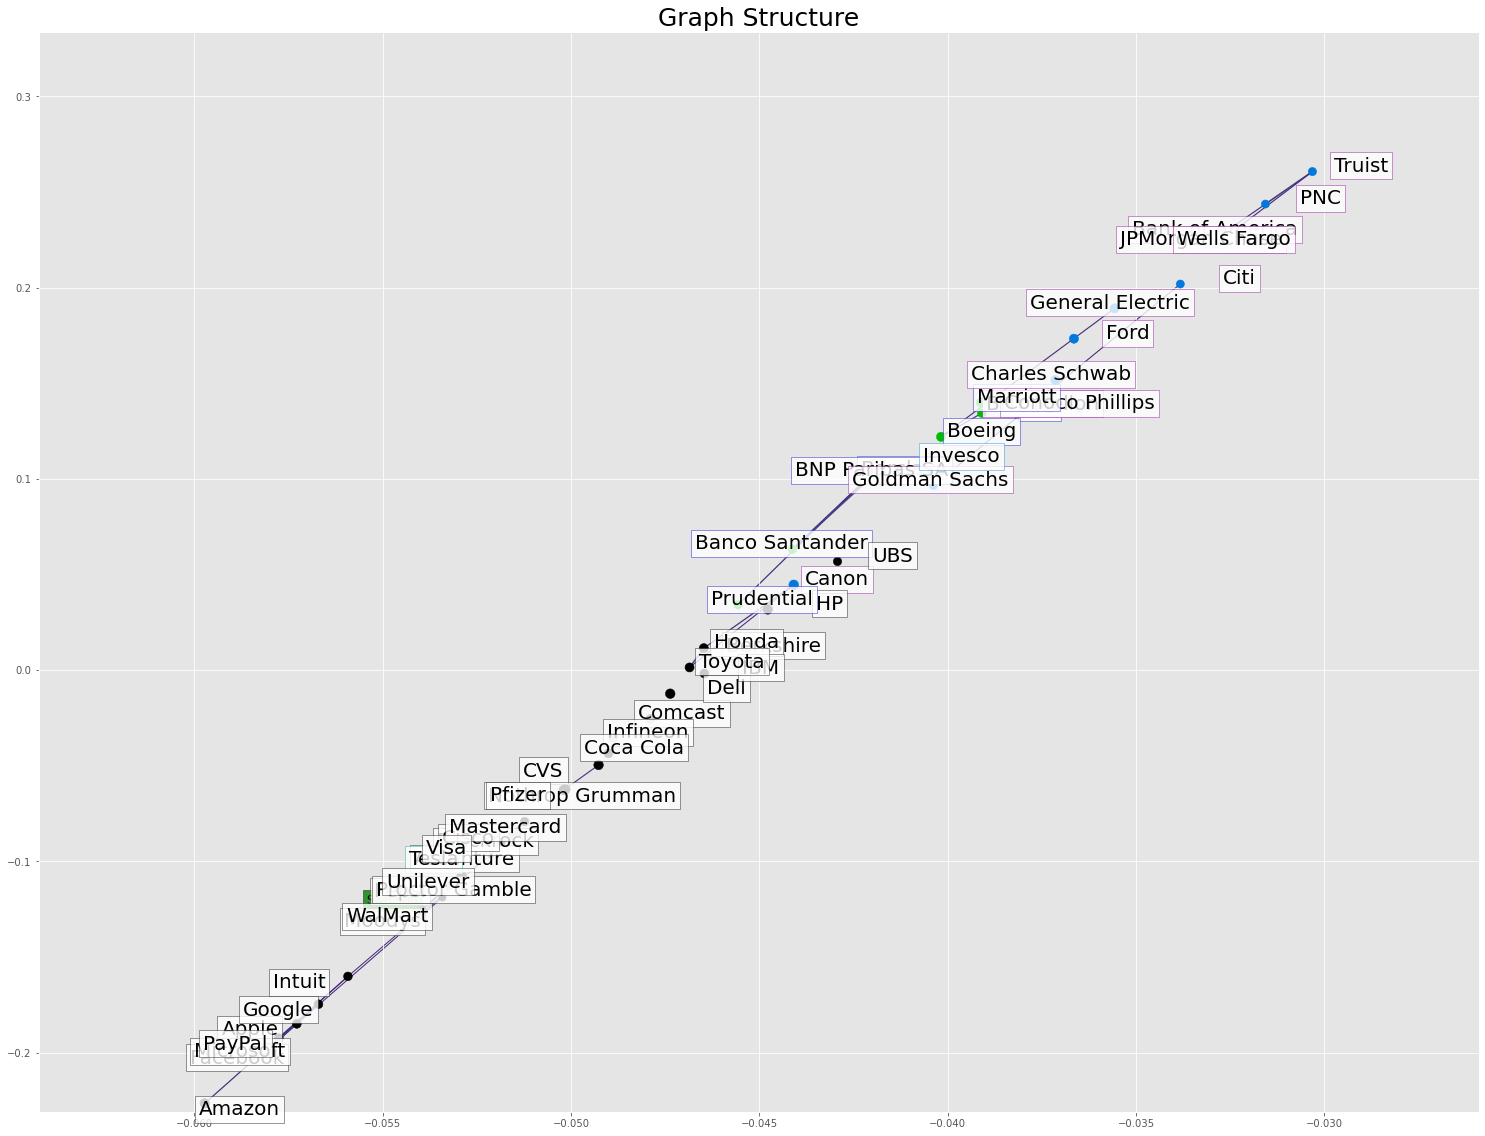

In [15]:
plt.figure(1, facecolor = 'w', figsize = (20,15))
plt.clf()
ax = plt.axes([0. ,0. ,1., 1.])

partial_corr = edge_model.precision_.copy()
d = 1/np.sqrt(np.diag(partial_corr))
partial_corr *= d
partial_corr *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_corr)) >= 0.10)

# Plot nodes
plt.scatter(embedding[0][:-12], embedding[1][:-12], c = labels[:-12], s = 100*d[:-12]**2, 
            cmap = plt.cm.nipy_spectral)

# Plot edges
start_idx, end_idx = np.where(non_zero)
start_idx = start_idx[:-12]
end_idx = end_idx[:-12]
segments = [[embedding[:,start], embedding[:,stop]] for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_corr[non_zero])[:-12]

lc = LineCollection(segments, 
                    zorder = 0, 
                    norm = plt.Normalize(0, .9*values.max()))
lc.set_array(values)
lc.set_linewidths(10*values)
ax.add_collection(lc)

for index, (name, label, (x,y)) in enumerate(zip(list(stock_dict.values())[:-12], 
                                                 labels[:-12], 
                                                 embedding.T[:-12])):
    
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[0]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    
    if this_dx > 0:
        horizontal_alignment = 'left'
        x -= 0.002
    else:
        horizontal_alignment = 'right'
        x += 0.002
    if this_dy > 0:
        vertical_alignment = 'bottom'
        y -= 0.002
    else:
        vertical_alignment = 'top'
        y += 0.002
        
    if name == 'S&P 500':
        plt.text(x, y, name, size=12,
                 horizontalalignment=horizontal_alignment,
                 verticalalignment=vertical_alignment,
                 bbox=dict(facecolor='g', alpha=0.8, edgecolor=plt.cm.nipy_spectral(label/n_label)))
        
    else:
        plt.text(x, y, name, size=20,
                 horizontalalignment=horizontal_alignment,
                 verticalalignment=vertical_alignment,
                 bbox=dict(facecolor='w', alpha=0.8, edgecolor=plt.cm.nipy_spectral(label/n_label)))
        
plt.xlim(embedding[0][:-12].min() - .15*embedding[0][:-12].ptp(), 
         embedding[0][:-12].max() + .15*embedding[0][:-12].ptp())
plt.ylim(embedding[1][:-12].min() - .15*embedding[0][:-12].ptp(), 
         embedding[1][:-12].max() + .15*embedding[1][:-12].ptp())
plt.title('Graph Structure', fontsize = 25)